## TODO

* Shuffle Samples before start get_batches [x]
* Resize Mask Gif [x]
* Test Images, Mask and Product between both [x]
* Create get_val_batches [x]
* Migrate the batch generator to a dedicated file in ../src/. [x]
* Test the new Augmentation Library [x]
* Implement the desired augmentation for the problem at hand [x]
* Create augmentation module and append it to the end of the batch function [ ]

**EXTRA**
* Regions of Interest [ ]

## Batch Generator

In [10]:
import cv2
from copy import copy
import constants as c
import glob
import math
import numpy as np
import os

from tqdm import tqdm
from random import shuffle
from PIL import Image

class CarvanaBatchGenerator():
    
    def __init__(self, mode, batch_size, dims_area=None, val_split=0.2):
        self.batch_size = batch_size
        self.dims_area = dims_area or (96,96)

        if mode is "train":
            # Create Train/Val Split
            self.val_split = 1 - val_split
            self.split_index = int(len(c.train_ids)*self.val_split)
            self.data = copy(c.train_ids)
            # Get Training and Validation IDs
            self.shuffle_train_val_ids()
            self.mode = 'Train'
        elif mode is "test":
            self.image_ids = c.test_ids
            self.n_images = len(c.test_ids)
            self.mode = 'Test'
        else:
            raise TypeError
            
    def shuffle_train_val_ids(self):
        shuffle(self.data)

        self.image_ids = self.data[:self.split_index]
        self.val_image_ids = self.data[self.split_index:]
            
    def batches_per_epoch(self):
        return int(len(self.image_ids) / self.batch_size)
    
    def val_batches_per_epoch(self):
        return int(len(self.val_image_ids) / self.batch_size)
        
    def get_batches(self):
        
        if self.mode is 'Train':
            self.shuffle_train_val_ids()
            for batch_ids in np.array_split(self.image_ids, self.batches_per_epoch()):
                yield self._get_tuple_batch_train(batch_ids)
        else:
            shuffle(self.image_ids)
            for batch_ids in np.array_split(self.image_ids, self.batches_per_epoch()):
                yield self._get_tuple_batch_test(batch_ids)
                
    def get_val_batches(self):
        shuffle(self.val_image_ids)
    
        for batch_ids in np.array_split(self.val_image_ids, self.val_batches_per_epoch()):
            yield self._get_tuple_batch_train(batch_ids)

    def _get_tuple_batch_train(self, batch_ids):
        batch_images = np.concatenate([ self.pre_processed_image(_id)[np.newaxis] for _id in batch_ids])
        batch_masks = np.concatenate([ self.pre_processed_mask(_id)[np.newaxis] for _id in batch_ids])

        return batch_images, batch_masks
    
    def _get_tuple_batch_test(self, batch_ids):
        batch_images = np.concatenate([ self.pre_processed_image(_id)[np.newaxis] for _id in batch_ids])

        return batch_images
    
    # Pre Processing Methods
    def pre_processed_image(self, id_):
        img = self._get_image_data(id_, self.mode)
        #TARGET_PIXEL_AREA = self.dims_area[0]*self.dims_area[1]

        #ratio = float(img.shape[1]) / float(img.shape[0])
        #new_h = int(math.sqrt(TARGET_PIXEL_AREA / ratio) + 0.5)
        #new_w = int((new_h * ratio) + 0.5)
        new_w, new_h = self.dims_area
        img = cv2.resize(img, (new_w,new_h))
        img = img/255.0
        
        return img
    
    def pre_processed_mask(self, id_):
        mask = self._get_image_data(id_, self.mode+'_mask')
        #TARGET_PIXEL_AREA = self.dims_area[0]*self.dims_area[1]

        #ratio = float(mask.shape[1]) / float(mask.shape[0])
        #new_h = int(math.sqrt(TARGET_PIXEL_AREA / ratio) + 0.5)
        #new_w = int((new_h * ratio) + 0.5)
        new_w, new_h = self.dims_area
        mask = cv2.resize(mask, (new_w,new_h))
        mask = mask/255.0
        return np.reshape(mask, (mask.shape[0], mask.shape[1], 1))
    
    # Private Methods
    def _rle_encode(self, img):
        pixels = img.flatten()
        pixels[0] = 0
        pixels[-1] = 0
        runs = np.where(pixels[1:] != pixels[:-1])[0] + 2
        runs[1::2] = runs[1::2] - runs[:-1:2]
    
        return ' '.join(str(x) for x in runs)
    
    def _rle_decode(self, mask_rle, shape):
        s = mask_rle.split()
        
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
        starts -= 1
        ends = starts + lengths
        img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
        
        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1
        
        return img.reshape(shape)
    
    def _get_filename(self, image_id, image_type):
        check_dir = False
        
        if "Train" == image_type:
            ext = 'jpg'
            data_path = c.TRAIN_DATA
            suffix = ''
        elif "Train_mask" in image_type:
            ext = 'gif'
            data_path = c.TRAIN_MASKS_DATA
            suffix = '_mask'
        elif "Test" in image_type:
            ext = 'jpg'
            data_path = c.TEST_DATA
            suffix = ''
        else:
            raise Exception("Image type '%s' is not recognized" % image_type)

        if check_dir and not os.path.exists(data_path):
            os.makedirs(data_path)

        return os.path.join(data_path, "{}{}.{}".format(image_id, suffix, ext))
    
    def _get_image_data(self, image_id, image_type, **kwargs):
        if 'mask' in image_type:
            img = self._get_image_data_pil(image_id, image_type, **kwargs)
        else:
            img = self._get_image_data_opencv(image_id, image_type, **kwargs)

        return img
    
    def _get_image_data_opencv(self, image_id, image_type, **kwargs):
        fname = self._get_filename(image_id, image_type)
        img = cv2.imread(fname)
        
        assert img is not None, "Failed to read image : %s, %s" % (image_id, image_type)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        return img
    
    def _get_image_data_pil(self, image_id, image_type, return_exif_md=False, return_shape_only=False):
        fname = self._get_filename(image_id, image_type)
        
        try:
            img_pil = Image.open(fname)
        except Exception as e:
            assert False, "Failed to read image : %s, %s. Error message: %s" % (image_id, image_type, e)

        if return_shape_only:
            return img_pil.size[::-1] + (len(img_pil.getbands()),)

        img = np.asarray(img_pil)
        
        assert isinstance(img, np.ndarray), "Open image is not an ndarray. Image id/type : %s, %s" % (image_id, image_type)
        
        if not return_exif_md:
            return img
        else:
            return img, img_pil._getexif()

## Example of Batch Generator usage for Carvana

(9, 96, 96, 3) (9, 96, 96, 1)


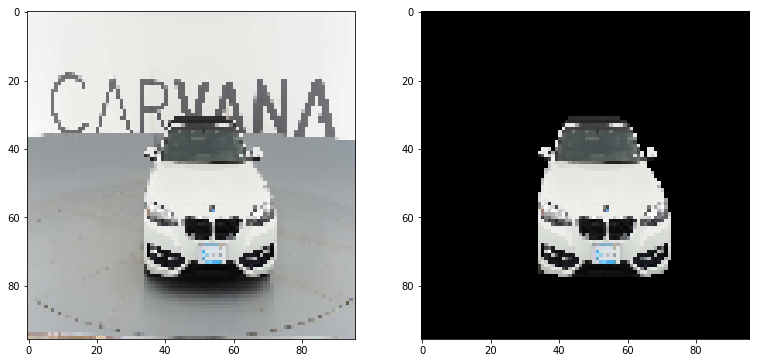

(9, 96, 96, 3) (9, 96, 96, 1)


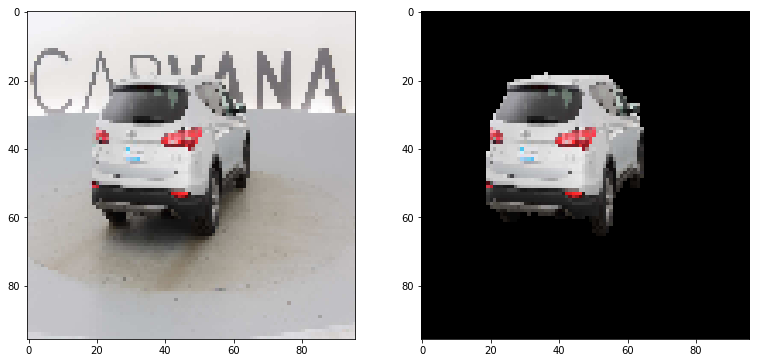

(96, 96, 3)


In [11]:
import matplotlib.pylab as plt
import seaborn as sns
import scipy.misc
import carvana_utils as carvana
import constants as c

batch_size = 8
bg = CarvanaBatchGenerator('train', batch_size, dims_area=(96,96))
l = []
for gen in bg.get_batches():
    print gen[0].shape, gen[1].shape

    img_masked = cv2.bitwise_and(np.uint8(gen[0][0,:]*255),
                                 np.uint8(gen[0][0,:]*255),
                                 mask = np.uint8(gen[1][0,:]*255))
    plt.figure(figsize=(20, 20))
    plt.subplot(131)
    plt.imshow(gen[0][0,:])
    plt.subplot(132)
    plt.imshow(img_masked)

    plt.show()
    break
    
for gen in bg.get_val_batches():
    print gen[0].shape, gen[1].shape

    img_masked = cv2.bitwise_and(np.uint8(gen[0][0,:]*255),
                                 np.uint8(gen[0][0,:]*255),
                                 mask = np.uint8(gen[1][0,:]*255))
    plt.figure(figsize=(20, 20))
    plt.subplot(131)
    plt.imshow(gen[0][0,:])
    plt.subplot(132)
    plt.imshow(img_masked)

    plt.show()
    break
    
bg = CarvanaBatchGenerator('test', batch_size, dims_area=(96,96))

for gen in bg.get_batches():
    print gen[0].shape
    break


## UNET Model in Keras

In [12]:
from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate
import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 96
img_cols = 96

smooth = 1.

### Cost Function

In [13]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

### Keras Model

In [14]:
def get_unet(img_rows, img_cols):
    inputs = Input((img_rows, img_cols, 3))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model

### Visualizing the UNET

In [ ]:
from keras_diagram import ascii
print(ascii(model))

### Training the Model

In [16]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [17]:
batch_size = 2
model = get_unet(96, 96)

generator = CarvanaBatchGenerator('train', batch_size, dims_area=(96,96))
model.fit_generator(generator.get_batches(),
                    steps_per_epoch=generator.batches_per_epoch(),
                    validation_data=generator.get_val_batches(),
                    validation_steps=generator.val_batches_per_epoch(),
                    epochs=2,
                    verbose=2,
                    callbacks=[model_checkpoint],
                    nb_worker=1)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., verbose=2, workers=1, validation_data=<generator..., steps_per_epoch=2035, epochs=2, callbacks=[<keras.ca..., validation_steps=509)`
  if sys.path[0] == '':


Epoch 1/2


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/System/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 763, in run
    self.__target(*self.__args, **self.__kwargs)
  File "/usr/local/lib/python2.7/site-packages/keras/utils/data_utils.py", line 560, in data_generator_task
    generator_output = next(self._generator)
StopIteration



StopIteration: 